# Tarea 3: Regularización y Optimización <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: Gabriel Rojas

**Fecha de entrega: 29 de Octubre**


In [ ]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente:
# !pip install -q ipdb
# import ipdb

# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-7s5qo90f/cc6204_e09bba99eb55418da7069201ac3aba98
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-7s5qo90f/cc6204_e09bba99eb55418da7069201ac3aba98


In [ ]:
# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# ingresa el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# anota el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

Connection stablished


# Parte 1: Regularización y Generalización



## 1a) Regularización por *weight decay*

In [ ]:
# Tu código debiera continuar así
class SGD():
  def __init__(self, parameters, lr, beta=0):
    # lo que sea necesario inicializar
    self.params = [p for p in parameters if p is not None]
    self.lr = lr
    self.beta = beta
  
  def step(self):
    # actualiza acá los parámetros a partir de los gradientes
    # y considera el nuevo valor beta
    for p in self.params:
      p.data *= (1-self.beta)
      p.data -= self.lr*p.grad

In [ ]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="1a", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = SGD([weight], lr=0.1, beta=0.1)
optimizer.step()

# Submit
corrector.submit(homework=3, question="1a", test=1, token=token, answer=weight)

Correct Test!


## 1b) Regularización por dropout

Para esta parte de la tarea, va a ser necesario modificar el método `forward` para que entregue el valor a la salida de la i-esima capa escondida. Para esto se modifica el método forward para que reciba un parámetro `output_layer` que indica luego de que capa escondida se espera el output.

In [ ]:
# Los gradientes se pueden implementar como parte de cada una de las funciones de activación
# En el caso de swish y celu devuelven una tupla (d_dx, d_dp)

def sig(T, gradient=False):
  if gradient:
    sigT = sig(T)
    return sigT * (1 - sigT)
  return torch.reciprocal(1 + torch.exp(-1 * T))
  
def tanh(T, gradient=False):
  if gradient:
    tanhT = tanh(T)
    return 1 - tanhT * tanhT
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

def relu(T, gradient=False):
  if gradient:
    outT = torch.zeros_like(T)
    outT[T>=0] = 1
    return outT
  return torch.max(T, torch.zeros_like(T))

def swish(T, beta=1, gradient=False):
  if gradient:
    sigbT = sig(beta * T)
    swishT = T * sigbT
    return sigbT + beta * swishT * (1 - sigbT), swishT * (T - swishT)
  return T * torch.reciprocal(1 + torch.exp(-beta * T))

def celu(T, alpha=1, gradient=False):
  if alpha == 0:
    raise ValueError("alpha cannot be 0")

  zeros = torch.zeros_like(T)
  Talpha = T / alpha
  
  if gradient:
    e = Talpha.exp()
    d_dx = torch.ones_like(T)
    d_dx[T<0] = e[T<0]
    zeros[T<0] = (celu(T)[T<0] - T[T<0] * e[T<0]) / alpha
    return d_dx, zeros # d_dx, d_da
  
  return torch.max(zeros, T) + torch.min(zeros, alpha * (Talpha).expm1())

def softmax(T, dim, estable=True):
  if estable:
    T -= T.max(dim=dim, keepdim=True)[0]  # keepdim=True => output has dim with size 1. Otherwise, dim is squeezed
  exp = torch.exp(T)
  return exp / torch.sum(exp, dim=dim, keepdim=True)  # keepdim=True => output has dim with size 1. Otherwise, dim is squeezed

In [ ]:
# Tu código debiera continuar como sigue

import torch.nn as nn
from torch.nn import Parameter, ParameterList
import math

def get_init_weights(shape):
  W = torch.randn(shape)
  # stdv = 1. / math.sqrt(W.size(1))
  # W.data.uniform_(-stdv, stdv)
  return Parameter(W)


class FFNN(nn.Module):
  def __init__(self, F, l_h, l_a, l_a_params, C, keep_prob=None):
    # debes crear los parámetros necesarios para hacer 
    # dropout en cada capa dependiendo de keep_prob
    super(FFNN, self).__init__()
       
    self.sizes = [F] + l_h + [C]
    self.Ws = ParameterList([get_init_weights((self.sizes[i], self.sizes[i+1])) for i in range(len(self.sizes)-1)])
    self.bs = ParameterList([Parameter(torch.zeros(h)) for h in self.sizes[1:]])
    self.fs = l_a
    if l_a_params is not None:
      self.fs_ps_mask = [Parameter(torch.tensor(p)) if p else None for p in l_a_params]
    else:
      self.fs_ps_mask = [None for _ in l_a]
    self.keep_prob = keep_prob
    if self.keep_prob is not None:
      self.generate_dropout_mask()
    else:
      self.drop = [1.0 for _ in range(len(self.sizes)-1)]
    self.fs_ps = ParameterList([p for p in self.fs_ps_mask if p])

  def generate_dropout_mask(self):
    device = self.Ws[0].device
    if self.keep_prob is not None:
      self.drop = [(torch.rand(self.sizes[i])<=self.keep_prob[i]).float().to(device) / self.keep_prob[i] for i in range(len(self.keep_prob))]
  
  def forward(self, x, predict=False):
    # debes modificar esta función para considerar el dropout
    # y preocuparte de no considerarlo cuando (predict=True)
    self.cacheU = [] #, self.cacheH = [], []
    if self.keep_prob is not None:
      self.generate_dropout_mask()
    for W, b, f, p, d in zip(self.Ws[:-1], self.bs[:-1], self.fs, self.fs_ps_mask, self.drop):
      if not predict:
        x *= d
      x = (torch.mm(x, W) + b)
      self.cacheU.append(x)
      x = f(x, p.item()) if p else f(x)
      # self.cacheH.append(x)
    return softmax(torch.mm(x, self.Ws[-1]) + self.bs[-1], dim=1)
  
  def backward(self, x, y, y_pred):
    # computar acá todos los gradientes considerando el dropout 
    current_grad = (y_pred - y) / y.size(0)
    
    for i in range(len(self.Ws)-1, 0, -1):
      if self.fs_ps_mask[i-1] is None:
        # funcion de activacion sin parametro
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1]).t() @ current_grad
      else:
        # funcion de activacion con parametro
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1].item()).t() @ current_grad
      self.bs[i].grad = current_grad.sum(dim=0)
      h_grad = current_grad @ self.Ws[i].t() * self.drop[i]
      
      if self.fs_ps_mask[i-1] is None:
        # funcion de activacion sin parametro
        current_grad = self.fs[i-1](self.cacheU[i-1], gradient=True) * h_grad 
      else:
        # funcion de activacion con parametro
        current_grad, p_grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1], gradient=True)
        current_grad *= h_grad 
        self.fs_ps_mask[i-1].grad = (p_grad * h_grad).sum()
    
    self.Ws[0].grad = x.t() @ current_grad
    self.bs[0].grad = current_grad.sum(dim=0)

In [ ]:
# Tests del API del curso
torch.manual_seed(0)
sample = torch.rand(1, 10)
red = FFNN(10, [1000], [sig], [None], 1, keep_prob=[1.0, 0.5])
y = red(sample)
output_mask = (y == 0)
percent = torch.sum(output_mask).item() / list(output_mask.size())[-1]

# Submit
corrector.submit(homework=3, question="1b", test=1, token=token, answer=percent)

Correct Test!


## 1c) Entrenamiento y generalización sobre MNIST 

In [ ]:
# Tu código de carga de datos, creación de la red, 
# entrenamiento/optimización y reportes acá
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Importamos funcionalidades útiles para mirar los datos.
from matplotlib.pyplot import subplots
from random import randint

from torch.utils.data import Dataset, DataLoader

# Descarga y almacena el conjunto de prueba de MNIST.
mnist_train_dataset = MNIST('mnist', train=True, transform=ToTensor(), download=True)
mnist_test_dataset = MNIST('mnist', train=False, transform=ToTensor(), download=True)
print('Cantidad total de datos de entrenamiento:',len(mnist_train_dataset))
print('Cantidad total de datos de testeo:',len(mnist_test_dataset))

Cantidad total de datos de entrenamiento: 60000
Cantidad total de datos de testeo: 10000


In [ ]:
# Tu código acá
def CELoss(Q, P, estable=True, epsilon=1e-8):
  N = Q.shape[0]
  if estable:
    Q = Q.clamp(epsilon, 1-epsilon)
  return -(P * Q.log()).sum()/N

In [ ]:
import time
import sys

def entrenar_FFNN(red, dataset, optimizador, epochs=1, batch_size=1, reports_every=1, device='cuda'):
  red.to(device)
  data = DataLoader(dataset, batch_size, shuffle=True)
  total=len(dataset)
  tiempo_epochs = 0
  loss, acc = [], []
  for e in range(1,epochs+1):  
    inicio_epoch = timer()
    
    for x, y in data:
      x, y = x.view(x.size(0), -1).float().to(device), y.to(device)
      
      y_pred = red(x)
      
      y_onehot = torch.zeros_like(y_pred)
      y_onehot[torch.arange(x.size(0)), y] = 1.
    
      red.backward(x, y_onehot, y_pred)

      optimizador.step()
      
    tiempo_epochs += timer() - inicio_epoch
    
    if e % reports_every == 0:
      X = dataset.data.view(len(dataset), -1).float().to(device)
      Y = dataset.targets.to(device)
      
      Y_PRED = red.forward(X).to(device)
      
      Y_onehot = torch.zeros_like(Y_PRED)
      Y_onehot[torch.arange(X.size(0)), Y] = 1.

      L_total = CELoss(Y_PRED, Y_onehot)
      loss.append(L_total)
      diff = Y-torch.argmax(Y_PRED,1)
      errores = torch.nonzero(diff).size(0)
      
      Acc=100*(total-errores)/total
      acc.append(Acc)

      sys.stdout.write(
            '\rEpoch:{0:03d}'.format(e) + ' Acc:{0:.2f}%'.format(Acc)
            + ' Loss:{0:.4f}'.format(L_total) 
            + ' Tiempo/epoch:{0:.3f}s'.format(tiempo_epochs/e))
  
  return loss, acc


In [ ]:
def calcula_acierto(red, dataset, batch_size=100, device='cuda'):
  red.to(device)
  data_loader = DataLoader(dataset, batch_size=batch_size)
  corrects_total = 0
  for i, (x, y) in enumerate(data_loader):
      x = x.view(-1, F).to(device)
      
      predictions = torch.max(red(x, predict=True), dim=1)[1]
      corrects = int((predictions == y.to(device)).sum())
      corrects_total += corrects
      
      if i % 10 == 0:
        print('iter {} of {}'.format(i, len(data_loader)))

  print('Acc: {}%'.format(100*corrects_total/len(dataset)))

In [ ]:
N, F, C = len(mnist_train_dataset), 28*28, 10
# Red sin dropout
red_mnist_no_dropout = FFNN(F, [500], [relu], [None], C)
optimizer_mnist_no_dropout = SGD(red_mnist_no_dropout.parameters(), 1e-3)

total_loss_mnist_no_dropout = []
total_acc_mnist_no_dropout = []

# Red 1 con dropout
red_mnist_dropout1 = FFNN(F, [500], [relu], [None], C, keep_prob=[1.0,0.8])
optimizer_mnist_dropout1 = SGD(red_mnist_dropout1.parameters(), 1e-3)

total_loss_mnist_dropout1 = []
total_acc_mnist_dropout1 = []

# Red 2 con dropout
red_mnist_dropout2 = FFNN(F, [500], [relu], [None], C, keep_prob=[1.0,0.5])
optimizer_mnist_dropout2 = SGD(red_mnist_dropout2.parameters(), 1e-3)

total_loss_mnist_dropout2 = []
total_acc_mnist_dropout2 = []

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
epochs = 30
batch_size = 32

with torch.no_grad():
  loss_mnist, acc_mnist = entrenar_FFNN(red_mnist_no_dropout, mnist_train_dataset, optimizer_mnist_no_dropout,
                                          epochs=epochs, batch_size=batch_size, device=device)
  total_loss_mnist_no_dropout += loss_mnist
  total_acc_mnist_no_dropout += acc_mnist

Epoch:030 Acc:92.40% Loss:1.3980 Tiempo/epoch:11.411s

In [ ]:
print("Acierto red mnist sin dropout")
calcula_acierto(red_mnist_no_dropout, mnist_test_dataset, device=device)

Acierto red mnist sin dropout
iter 0 of 100
iter 10 of 100
iter 20 of 100
iter 30 of 100
iter 40 of 100
iter 50 of 100
iter 60 of 100
iter 70 of 100
iter 80 of 100
iter 90 of 100
Acc: 91.64%


In [ ]:
with torch.no_grad():
  loss_mnist, acc_mnist = entrenar_FFNN(red_mnist_dropout1, mnist_train_dataset, optimizer_mnist_dropout1,
                                          epochs=epochs, batch_size=batch_size, device=device)
  total_loss_mnist_dropout1 += loss_mnist
  total_acc_mnist_dropout1 += acc_mnist

Epoch:030 Acc:92.34% Loss:1.4078 Tiempo/epoch:11.945s

In [ ]:
print("Acierto red mnist con dropout 0.8")
calcula_acierto(red_mnist_dropout1, mnist_test_dataset, device=device)


Acierto red mnist con dropout 0.8 y 0.8
iter 0 of 100
iter 10 of 100
iter 20 of 100
iter 30 of 100
iter 40 of 100
iter 50 of 100
iter 60 of 100
iter 70 of 100
iter 80 of 100
iter 90 of 100
Acc: 91.26%


In [ ]:
with torch.no_grad():
  loss_mnist, acc_mnist = entrenar_FFNN(red_mnist_dropout2, mnist_train_dataset, optimizer_mnist_dropout2,
                                          epochs=epochs, batch_size=batch_size, device=device)
  total_loss_mnist_dropout2 += loss_mnist
  total_acc_mnist_dropout2 += acc_mnist

Epoch:030 Acc:92.35% Loss:1.4084 Tiempo/epoch:11.663s

In [ ]:
print("Acierto red mnist con dropout 0.5")
calcula_acierto(red_mnist_dropout2, mnist_test_dataset, device=device)


Acierto red mnist con dropout 0.7 y 0.5
iter 0 of 100
iter 10 of 100
iter 20 of 100
iter 30 of 100
iter 40 of 100
iter 50 of 100
iter 60 of 100
iter 70 of 100
iter 80 of 100
iter 90 of 100
Acc: 90.81%


Podemos ver que la accuracy obtenidad es bastanate parecidad para varias epocas de los 3 modelos

Graficos de loss y accuracy durante el **training**

La accuracy verdadera es la anteriormente obtenida con el dataset de testing

In [ ]:
import matplotlib.pyplot as plt

def plot_results(loss, acc):
  # Muestra dos figuras: 
  #  (1) gráfico para la lista `loss` (Loss) y 
  #  (2) gráfico para la lista `acc` (Accuracy)

  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r')
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title("Accuracy")    
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('acc')
  ax2.plot(acc, c='b')
  f2.show()

Acierto red mnist sin dropout


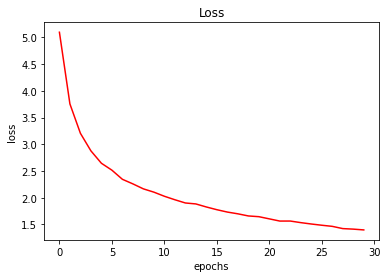

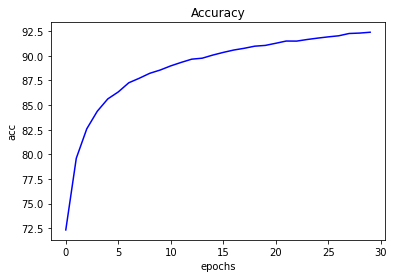

In [ ]:
print("Acierto red mnist sin dropout")
plot_results(total_loss_mnist_no_dropout, total_acc_mnist_no_dropout)

Acierto red mnist con dropout 0.8 y 0.8


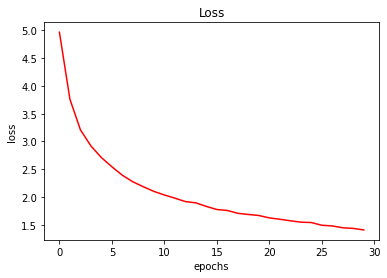

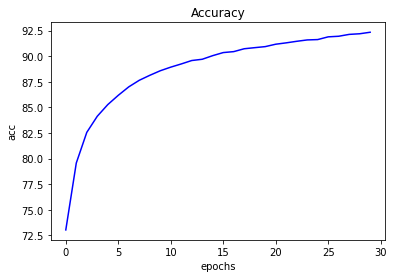

In [ ]:
print("Acierto red mnist con dropout 0.8")
plot_results(total_loss_mnist_dropout1, total_acc_mnist_dropout1)

Acierto red mnist con dropout 0.7 y 0.5


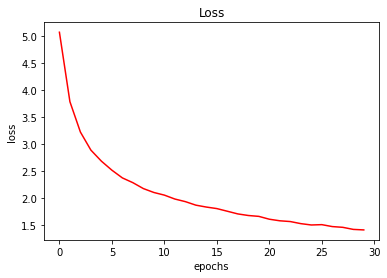

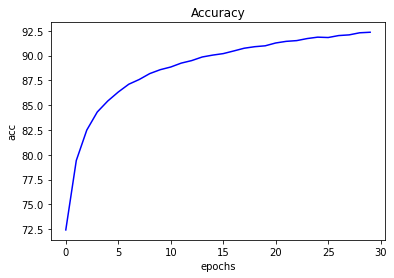

In [ ]:
print("Acierto red mnist con dropout 0.5")
plot_results(total_loss_mnist_dropout2, total_acc_mnist_dropout2)

# Parte 2: Optimización

## 2a) Inicialización de Xavier/He

Para los test de esta parte vamos a necesitar que modifiques tu código para que se pueda entregar valores predeterminados de `r`. Ahora tu código para las inicializaciones debe ser: `xavier_init(first_dim, second_dim, r=None)`, `he_init(first_dim, second_dim, r=None)`.

In [ ]:
# Tu código debiera continuar como sigue
def xavier_init(first_dim, second_dim, r=None):
  res = torch.sqrt(torch.reciprocal(torch.tensor(first_dim)))
  res = torch.ones([first_dim, second_dim]) * res
  if r is not None:
    res = r * res
  return res
  

def he_init(first_dim, second_dim, r=None):
  res = torch.sqrt(2 * torch.reciprocal(torch.tensor(first_dim)))
  res = torch.ones([first_dim, second_dim]) * res
  if r is not None:
    res = r * res
  return res

In [ ]:
# Tests del API del curso
r_xavier = corrector.get_test_data(homework=3, question="2a", test=1, token=token)
r_he = corrector.get_test_data(homework=3, question="2a", test=2, token=token)

w_xavier = xavier_init(50, 50, torch.tensor(r_xavier))
w_he = he_init(50, 50, torch.tensor(r_he))

corrector.submit(homework=3, question="2a", test=1, token=token, answer=w_xavier)
corrector.submit(homework=3, question="2a", test=2, token=token, answer=w_he)

Correct Test!
Correct Test!


## 2b) Descenso de gradiente con momentum

In [ ]:
# Tu código debiera continuar así

class SGD():
  def __init__(self, parameters, lr, beta=0, momentum=0):
    # lo que sea necesario inicializar
    self.params = [p for p in parameters if p is not None]
    self.lr = lr
    self.beta = beta
    self.momentum = momentum
    self.velocity = [torch.zeros_like(p) for p in self.params]
  
  def step(self):
    # actualiza acá los parámetros a partir de los gradientes
    # y considerando el valor de momentum que acabámos de agregar
    for i in range(len(self.params)):
      self.velocity[i] *= self.momentum
      self.velocity[i] -= self.lr * self.params[i].grad
      self.params[i].data += self.velocity[i]

In [ ]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="2b", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = SGD([weight], lr=0.1, momentum=0.9)
optimizer.step()

# Submit
corrector.submit(homework=3, question="2b", test=1, token=token, answer=weight)
optimizer.step()
corrector.submit(homework=3, question="2b", test=2, token=token, answer=weight)

Correct Test!
Correct Test!


## 2c) RMSProp

In [ ]:
# Tu código acá

class RMSProp():
  def __init__(self, parameters, lr=0.001, beta=0.9, epsilon=1e-8):
    # en este caso debes inicializar la variable que acumula
    # el promedio exponencial de los cuadrados
    self.params = [p for p in parameters if p is not None]
    self.lr = lr
    self.beta = beta
    self.epsilon = epsilon
    self.S = [torch.zeros_like(p) for p in self.params]
  
  def step(self):
    # actualiza acá los parámetros a partir de los gradientes
    # y la corrección según S
    for i in range(len(self.params)):
      self.S[i] *= self.beta
      self.S[i] += (1 - self.beta) * ((self.params[i].grad) ** 2)
      sqrt = torch.sqrt(self.S[i]) + self.epsilon
      self.params[i].data -= self.lr * torch.reciprocal(sqrt) * self.params[i].grad

In [ ]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="2c", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = RMSProp([weight], lr=0.001, beta=0.9, epsilon=1e-8)
optimizer.step()

# Submit
corrector.submit(homework=3, question="2c", test=1, token=token, answer=weight)
optimizer.step()
corrector.submit(homework=3, question="2c", test=2, token=token, answer=weight)

Correct Test!
Correct Test!


## 2d) Adam

In [ ]:
# Tu código acá

class Adam():
  def __init__(self, parameters, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    # en este caso debes inicializar la variable que acumula
    # el promedio exponencial de los cuadrados
    self.params = [p for p in parameters if p is not None]
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.n = 0
    self.P = [torch.zeros_like(p) for p in self.params]
    self.S = [torch.zeros_like(p) for p in self.params]
    self.P_bar = [torch.zeros_like(p) for p in self.params]
    self.S_bar = [torch.zeros_like(p) for p in self.params]
  
  def step(self):
    # actualiza acá los parámetros a partir de los gradientes
    # y la corrección según S
    self.n += 1
    for i in range(len(self.params)):
      self.P[i] *= self.beta1
      self.P[i] += (1 - self.beta1) * self.params[i].grad
      self.S[i] *= self.beta2
      self.S[i] += (1 - self.beta2) * (self.params[i].grad ** 2)
      self.P_bar[i] = self.P[i] * 1/ (1 - self.beta1 ** self.n)
      self.S_bar[i] = self.S[i] * 1 / (1 - self.beta2 ** self.n)
      sqrt = torch.sqrt(self.S_bar[i]) + self.epsilon
      self.params[i].data -= self.lr * torch.reciprocal(sqrt) * self.P_bar[i]
    

In [ ]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="2d", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = Adam([weight], lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8)
optimizer.step()

# Submit
corrector.submit(homework=3, question="2d", test=1, token=token, answer=weight)
optimizer.step()
corrector.submit_check_some(homework=3, question="2d", tests=[2, 3], token=token,
                            answer_dict={2: weight, 3: weight}, required_number=1)

Correct Test!
Correct Test!


## 2e) Entrenamiento en MNIST 

Usa tu red neuronal para entrenar con los datos de MNIST y compara cómo cambian las curvas de entrenamiento dependiendo de factores como la inicialización y los algoritmos que utilices. Presenta al menos dos gráficos en donde compares. Por ejemplo, puedes presentar uno que para la misma estrategia de inicialización, los tres algoritmos de optimización para varias épocas y cómo evoluciona la pérdida y el acierto. En cada caso comenta que conclusiones puedes sacar. Algunos ejemplos de preguntas que podrías tratar de responder son:
* ¿cómo afecta el algoritmo de optimización al tiempo de convergencia de la red para los datos de entrenamiento?
* ¿cómo afecta el algoritmo de optimización en el acierto alcanzado por la red en los datos de prueba?
* Si haces la parte opcional de Batch Normalization, puedes también preguntarte cosas como si aplicar, o no, BN afecta a todos los algoritmos de optimización por igual.

In [ ]:
# Aqui el codigo para entrenar en MNIST

# Tu código debiera continuar como sigue
def get_init_weights(shape, init=None):
  W = torch.randn(shape)
  if init == "xavier":
    W = xavier_init(*shape, r=W)
  if init == "he":
    W = he_init(*shape, r=W)
  return Parameter(W)


class FFNN(nn.Module):
  def __init__(self, F, l_h, l_a, l_a_params, C, keep_prob=None, init=None):
    # debes crear los parámetros necesarios para hacer 
    # dropout en cada capa dependiendo de keep_prob
    super(FFNN, self).__init__()
       
    self.sizes = [F] + l_h + [C]
    if init is not None:
      if init == "xavier" or init == "he":
        self.Ws = ParameterList([get_init_weights((self.sizes[i], self.sizes[i+1]), init=init) for i in range(len(self.sizes)-1)])
      else:
        print('Invalid initiation, use "xavier", "he" or "None"')
        raise
    else:
      self.Ws = ParameterList([get_init_weights((self.sizes[i], self.sizes[i+1])) for i in range(len(self.sizes)-1)])
    self.bs = ParameterList([Parameter(torch.zeros(h)) for h in self.sizes[1:]])
    self.fs = l_a
    if l_a_params is not None:
      self.fs_ps_mask = [Parameter(torch.tensor(p)) if p else None for p in l_a_params]
    else:
      self.fs_ps_mask = [None for _ in l_a]
    self.keep_prob = keep_prob
    if self.keep_prob is not None:
      self.generate_dropout_mask()
    else:
      self.drop = [1.0 for _ in range(len(self.sizes)-1)]
    self.fs_ps = ParameterList([p for p in self.fs_ps_mask if p])

  def generate_dropout_mask(self):
    device = self.Ws[0].device
    if self.keep_prob is not None:
      self.drop = [(torch.rand(self.sizes[i])<=self.keep_prob[i]).float().to(device) / self.keep_prob[i] for i in range(len(self.keep_prob))]
  
  def forward(self, x, predict=False):
    # debes modificar esta función para considerar el dropout
    # y preocuparte de no considerarlo cuando (predict=True)
    self.cacheU = [] #, self.cacheH = [], []
    if self.keep_prob is not None:
      self.generate_dropout_mask()
    for W, b, f, p, d in zip(self.Ws[:-1], self.bs[:-1], self.fs, self.fs_ps_mask, self.drop):
      if not predict:
        x *= d
      x = (torch.mm(x, W) + b)
      self.cacheU.append(x)
      x = f(x, p.item()) if p else f(x)
      # self.cacheH.append(x)
    return softmax(torch.mm(x, self.Ws[-1]) + self.bs[-1], dim=1)
  
  def backward(self, x, y, y_pred):
    # computar acá todos los gradientes considerando el dropout 
    current_grad = (y_pred - y) / y.size(0)
    
    for i in range(len(self.Ws)-1, 0, -1):
      if self.fs_ps_mask[i-1] is None:
        # funcion de activacion sin parametro
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1]).t() @ current_grad
      else:
        # funcion de activacion con parametro
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1].item()).t() @ current_grad
      self.bs[i].grad = current_grad.sum(dim=0)
      h_grad = current_grad @ self.Ws[i].t() * self.drop[i]
      
      if self.fs_ps_mask[i-1] is None:
        # funcion de activacion sin parametro
        current_grad = self.fs[i-1](self.cacheU[i-1], gradient=True) * h_grad 
      else:
        # funcion de activacion con parametro
        current_grad, p_grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1], gradient=True)
        current_grad *= h_grad 
        self.fs_ps_mask[i-1].grad = (p_grad * h_grad).sum()
    
    self.Ws[0].grad = x.t() @ current_grad
    self.bs[0].grad = current_grad.sum(dim=0)

In [ ]:
N, F, C = len(mnist_train_dataset), 28*28, 10

# Red con optimizador adam
red_mnist_adam = FFNN(F, [512,1024,128], [relu,relu,relu], [None,None,None], C, keep_prob=[1.0,0.5,0.5,0.5], init="xavier")
red_mnist_adam.to(device)
optimizer_mnist_adam = Adam(red_mnist_adam.parameters())

total_loss_mnist_adam = []
total_acc_mnist_adam = []

red_mnist_rmsprop = FFNN(F, [512,1024,128], [relu,relu,relu], [None,None,None], C, keep_prob=[1.0,0.5,0.5,0.5], init="xavier")
red_mnist_rmsprop.to(device)
optimizer_mnist_rmsprop = RMSProp(red_mnist_rmsprop.parameters())

total_loss_mnist_rmsprop = []
total_acc_mnist_rmsprop = []

red_mnist_sgd = FFNN(F, [512,1024,128], [relu,relu,relu], [None,None,None], C, keep_prob=[1.0,0.5,0.5,0.5], init="xavier")
red_mnist_sgd.to(device)
optimizer_mnist_sgd = SGD(red_mnist_sgd.parameters(), 1e-3, momentum=0.9)

total_loss_mnist_sgd = []
total_acc_mnist_sgd = []

In [ ]:
with torch.no_grad():
  loss_mnist, acc_mnist = entrenar_FFNN(red_mnist_adam, mnist_train_dataset, optimizer_mnist_adam,
                                          epochs=epochs, batch_size=batch_size, device=device)
  total_loss_mnist_adam += loss_mnist
  total_acc_mnist_adam += acc_mnist

Epoch:030 Acc:97.99% Loss:0.3617 Tiempo/epoch:18.134s

In [ ]:
calcula_acierto(red_mnist_adam, mnist_test_dataset, device=device)

iter 0 of 100
iter 10 of 100
iter 20 of 100
iter 30 of 100
iter 40 of 100
iter 50 of 100
iter 60 of 100
iter 70 of 100
iter 80 of 100
iter 90 of 100
Acc: 98.03%


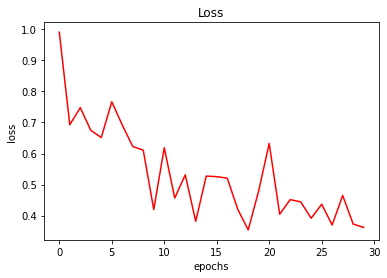

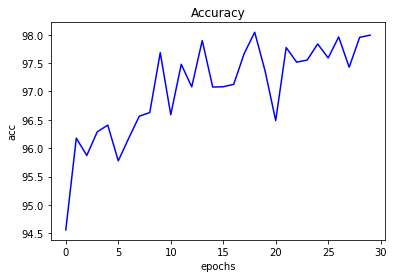

In [ ]:
plot_results(total_loss_mnist_adam, total_acc_mnist_adam)

In [ ]:
with torch.no_grad():
  loss_mnist, acc_mnist = entrenar_FFNN(red_mnist_rmsprop, mnist_train_dataset, optimizer_mnist_rmsprop,
                                          epochs=epochs, batch_size=batch_size, device=device)
  total_loss_mnist_rmsprop += loss_mnist
  total_acc_mnist_rmsprop += acc_mnist

Epoch:030 Acc:96.99% Loss:0.5494 Tiempo/epoch:16.307s

In [ ]:
calcula_acierto(red_mnist_rmsprop, mnist_test_dataset, device=device)

iter 0 of 100
iter 10 of 100
iter 20 of 100
iter 30 of 100
iter 40 of 100
iter 50 of 100
iter 60 of 100
iter 70 of 100
iter 80 of 100
iter 90 of 100
Acc: 96.2%


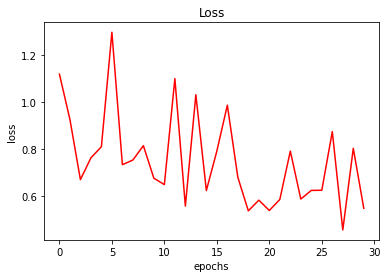

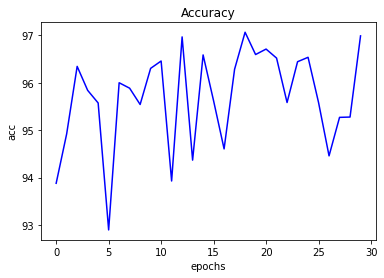

In [ ]:
plot_results(total_loss_mnist_rmsprop, total_acc_mnist_rmsprop)

In [ ]:
with torch.no_grad():
  loss_mnist, acc_mnist = entrenar_FFNN(red_mnist_sgd, mnist_train_dataset, optimizer_mnist_sgd,
                                          epochs=epochs, batch_size=batch_size, device=device)
  total_loss_mnist_sgd += loss_mnist
  total_acc_mnist_sgd += acc_mnist

Epoch:030 Acc:97.51% Loss:0.4486 Tiempo/epoch:14.609s

In [ ]:
calcula_acierto(red_mnist_sgd, mnist_test_dataset, device=device)

iter 0 of 100
iter 10 of 100
iter 20 of 100
iter 30 of 100
iter 40 of 100
iter 50 of 100
iter 60 of 100
iter 70 of 100
iter 80 of 100
iter 90 of 100
Acc: 98.16%


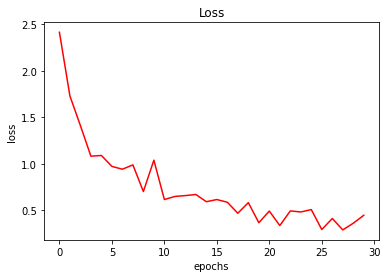

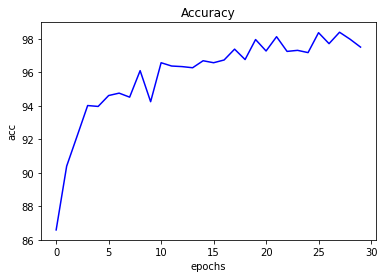

In [ ]:
plot_results(total_loss_mnist_sgd, total_acc_mnist_sgd)

Podemos ver que adam tomo mayor cantidad de epocas en coverger los datos de la red, mientras que rmsprop converge rapidamente los datos de la red, aproxumadamente en la epoca 3 y sgd con momentum tambien toma tiempo en converger los datos. \\
Tambien se puede ver que adam y sgd con momentum consiguen mejor acierto en el dataset de test, esto probablemente debido a la manera en que modifica los datos de la red, mientras que rmsprop consigue un menor acierto.

# Parte 3 (Opcional): Batch Normalization

In [ ]:
# Tu código debiera continuar como sigue

class FFNN():
  def __init__(self, F, l_h, l_a, l_a_params, C, l_keep_prob, bn=None):
    # debes crear los parámetros necesarios para las capas de
    # batch normalizacion
    pass
  
  def forward(x, predict=False):
    # debes modificar esta función para considerar las capas para las que se
    # usará batch normalization
    # también debes preocuparte de guardar los datos estadísticos que se
    # usaran en tiempo de test (predict=True)
    pass
  
  def backward(x,y,y_pred):
    # computar acá todos los gradientes considerando las capas de 
    # batch normalization
    # no olvides considerar los nuevos parámetros entrenables.
    pass